In [1]:
import scanpy as sc
import numpy as np

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
adata=sc.read_h5ad("./data/t1d.h5ad")
print(adata)
print(adata.X[:10,:10])

AnnData object with n_obs × n_vars = 69645 × 26099
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'disease_state', 'cell_label', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'
  (0, 1)	1.076574683189392
  (3, 1)	0.6022599935531616
  (4, 1)	0.32389

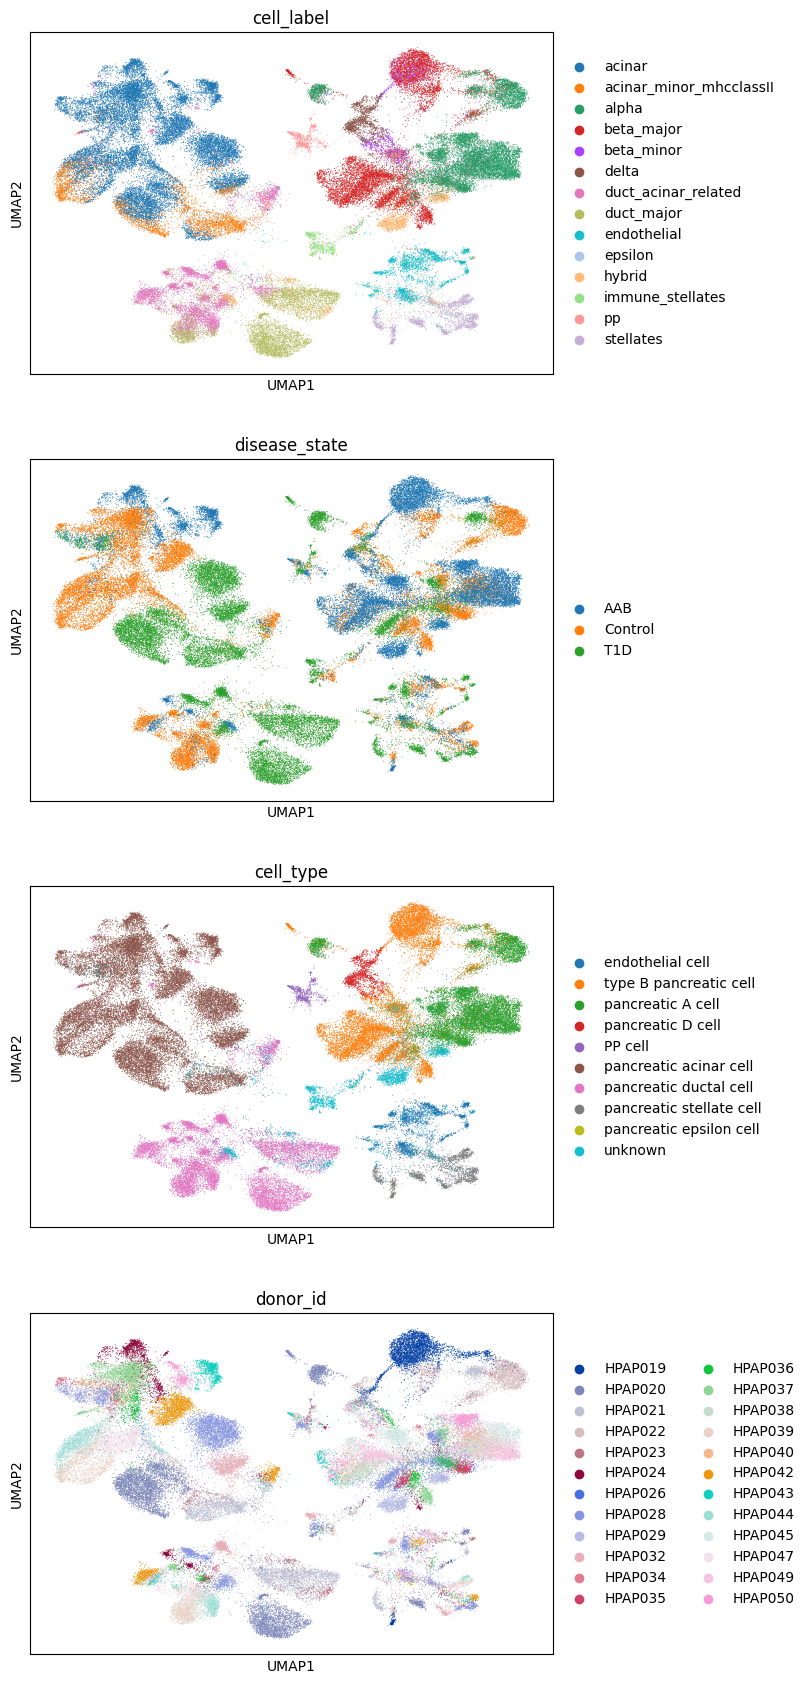

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["cell_label","disease_state","cell_type","donor_id"],ncols=1)

# If we randomly permute the donor_id for each cell

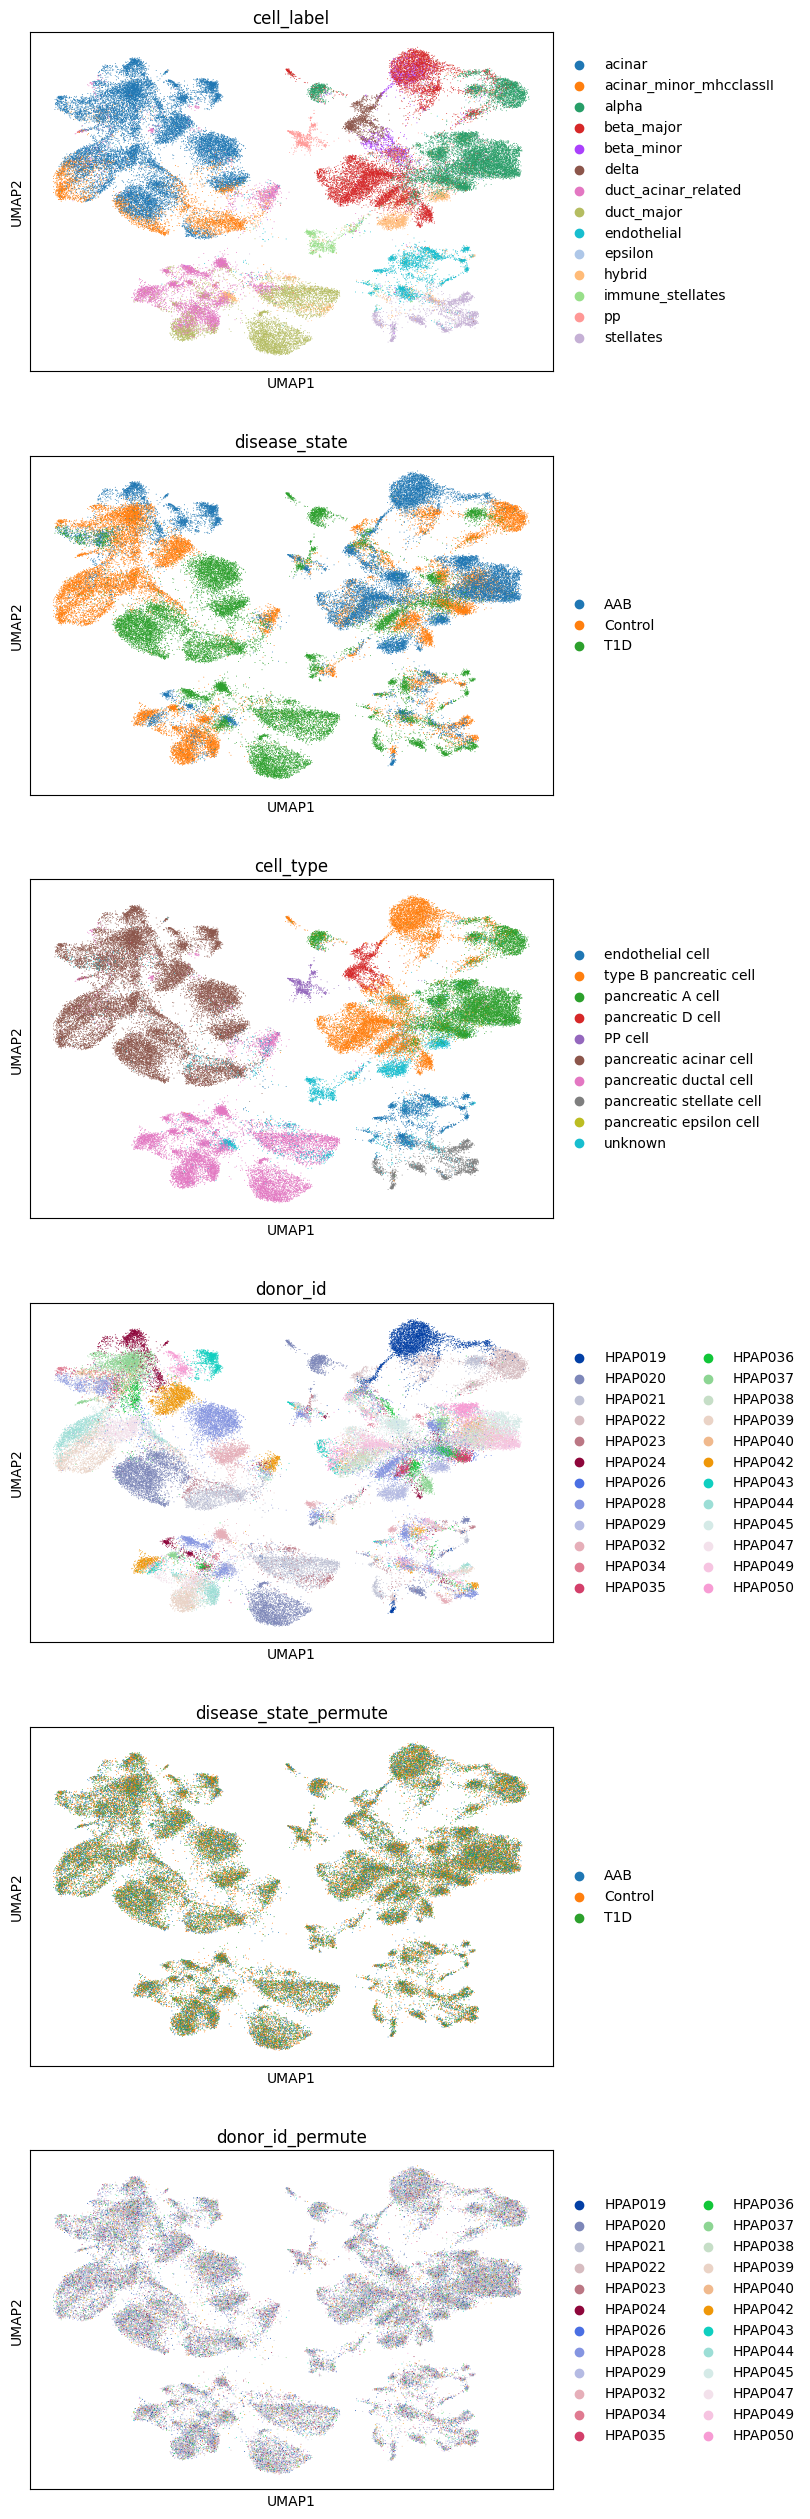

In [4]:
import pandas as pd
perm_indices = np.random.permutation(adata.obs.index)
df = pd.DataFrame(adata.obs[['disease_state','donor_id']].copy())
df_permuted=df.loc[perm_indices, ['disease_state','donor_id']].reset_index(drop=True)
adata.obs['disease_state_permute']=df_permuted.loc[:,'disease_state'].values
adata.obs['donor_id_permute']=df_permuted.loc[:,'donor_id'].values
sc.pl.umap(adata,color=["cell_label","disease_state","cell_type","donor_id",'disease_state_permute','donor_id_permute'],ncols=1)

In [5]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="disease_state_permute", contorl_name='Control', num_hvg=2000, require_batch=True,
                            batch_key='donor_id_permute',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=2048, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./t1d_fake_all/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./t1d_fake_all/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[donor_id_permute] back up to adata.obs['batch_backup']
Original adata.obs[disease_state_permute] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'Control': 0, 'T1D': 1, 'AAB': 2}
Condition mapping to adata.obs['batch']: {'donor_id_permute': {'HPAP044': 0, 'HPAP039': 1, 'HPAP022': 2, 'HPAP032': 3, 'HPAP049': 4, 'HPAP043': 5, 'HPAP037': 6, 'HPAP021': 7, 'HPAP050': 8, 'HPAP020': 9, 'HPAP024': 10, 'HPAP036': 11, 'HPAP047': 12, 'HPAP042': 13, 'HPAP028': 14, 'HPAP019': 15, 'HPAP045': 16, 'HPAP029': 17, 'HPAP023': 18, 'HPAP038': 19, 'HPAP035': 20, 'HPAP040': 21, 'HPAP034': 22, 'HPAP026': 23}}
Unique batch mapping: {'HPAP044': 0, 'HPAP039': 1, 'HPAP022': 2, 'HPAP032': 3, 'HPAP049': 4, 'HPAP043': 5, 'HPAP037': 6, 'HPAP021': 7, 'HPAP050': 8, 'HPAP020': 9, 'HPAP024': 10, 'HPAP036': 11, 'HPAP047': 12, 'HPAP042': 13, 'HPAP028': 14, 'HPAP019': 15, 'HPAP045': 16, 'HPAP029': 1

Calculating the clusters
Unique groups: ['0_Control' '10_AAB' '11_Control' '12_Control' '13_Control' '14_T1D'
 '15_AAB' '16_AAB' '17_AAB' '18_T1D' '19_AAB' '1_Control' '20_Control'
 '21_Control' '22_Control' '23_Control' '2_Control' '3_T1D' '4_AAB'
 '5_AAB' '6_Control' '7_T1D' '8_AAB' '9_T1D']


Finished clustering
Data preprocessing done


Remaining number of cells: 69645
Too few epoches (steps, if rigorously speaking). Changing epoch to 22 to adjust for number of cells
Require batch: True
Batch name to number mapping (may be used for search for saved adata):
 {'donor_id_permute': {'HPAP044': 0, 'HPAP039': 1, 'HPAP022': 2, 'HPAP032': 3, 'HPAP049': 4, 'HPAP043': 5, 'HPAP037': 6, 'HPAP021': 7, 'HPAP050': 8, 'HPAP020': 9, 'HPAP024': 10, 'HPAP036': 11, 'HPAP047': 12, 'HPAP042': 13, 'HPAP028': 14, 'HPAP019': 15, 'HPAP045': 16, 'HPAP029': 17, 'HPAP023': 18, 'HPAP038': 19, 'HPAP035': 20, 'HPAP040': 21, 'HPAP034': 22, 'HPAP026': 23}}
Condition name to number mapping (may be used for search for saved adata):
 {'Control': 0, 'T1D': 1, 'AAB': 2}
Preprocessing time: 55.39179 seconds


Overall Progress:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 1/22 | All Loss: 82.7526 | Neighborhood Loss: 52.4714 | Triplet Loss: 6.8401 | Reconstruction Loss: 9.2140 | Independent Loss: 24.0343 | KL Loss: 0.3385 | Commitment Loss: 0.5652 | Dependent Loss: -10.7108


Resetting 769 unused embeddings.


Resetting 752 unused embeddings.


Resetting 766 unused embeddings.
Resetting 792 unused embeddings.


Resetting 793 unused embeddings.


Resetting 783 unused embeddings.
Resetting 755 unused embeddings.


Resetting 772 unused embeddings.
Resetting 759 unused embeddings.


Resetting 799 unused embeddings.
Resetting 792 unused embeddings.


Resetting 795 unused embeddings.
Resetting 776 unused embeddings.


Resetting 740 unused embeddings.
Resetting 785 unused embeddings.


Resetting 775 unused embeddings.
Resetting 783 unused embeddings.


Resetting 786 unused embeddings.


Resetting 781 unused embeddings.
Resetting 776 unused embeddings.


Resetting 761 unused embeddings.
Resetting 774 unused embeddings.


Resetting 794 unused embeddings.
Resetting 747 unused embeddings.


Resetting 739 unused embeddings.
Resetting 786 unused embeddings.


Resetting 779 unused embeddings.
Resetting 785 unused embeddings.


Resetting 783 unused embeddings.


Resetting 764 unused embeddings.
Resetting 768 unused embeddings.


Resetting 787 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 1


Epoch: 2/22 | All Loss: 60.6217 | Neighborhood Loss: 47.1949 | Triplet Loss: 2.7932 | Reconstruction Loss: 6.3878 | Independent Loss: 12.4752 | KL Loss: 0.1786 | Commitment Loss: 0.2597 | Dependent Loss: -8.6676


Resetting 706 unused embeddings.
Resetting 682 unused embeddings.


Resetting 754 unused embeddings.
Resetting 803 unused embeddings.


Resetting 723 unused embeddings.
Resetting 753 unused embeddings.


Resetting 700 unused embeddings.
Resetting 755 unused embeddings.


Resetting 738 unused embeddings.
Resetting 801 unused embeddings.


Resetting 787 unused embeddings.
Resetting 823 unused embeddings.


Resetting 736 unused embeddings.
Resetting 688 unused embeddings.


Resetting 715 unused embeddings.
Resetting 780 unused embeddings.


Resetting 703 unused embeddings.


Resetting 686 unused embeddings.
Resetting 757 unused embeddings.


Resetting 712 unused embeddings.
Resetting 732 unused embeddings.


Resetting 771 unused embeddings.
Resetting 771 unused embeddings.


Resetting 741 unused embeddings.
Resetting 704 unused embeddings.


Resetting 799 unused embeddings.
Resetting 750 unused embeddings.


Resetting 671 unused embeddings.
Resetting 755 unused embeddings.


Resetting 694 unused embeddings.
Resetting 752 unused embeddings.


Resetting 720 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 2


Epoch: 3/22 | All Loss: 54.8280 | Neighborhood Loss: 43.6164 | Triplet Loss: 1.8724 | Reconstruction Loss: 5.9184 | Independent Loss: 11.7256 | KL Loss: 0.1469 | Commitment Loss: 0.1955 | Dependent Loss: -8.6472


Resetting 668 unused embeddings.
Resetting 656 unused embeddings.


Resetting 738 unused embeddings.
Resetting 769 unused embeddings.


Resetting 687 unused embeddings.
Resetting 716 unused embeddings.


Resetting 668 unused embeddings.
Resetting 700 unused embeddings.


Resetting 731 unused embeddings.
Resetting 768 unused embeddings.


Resetting 739 unused embeddings.
Resetting 796 unused embeddings.


Resetting 695 unused embeddings.
Resetting 651 unused embeddings.


Resetting 672 unused embeddings.
Resetting 749 unused embeddings.


Resetting 688 unused embeddings.
Resetting 639 unused embeddings.


Resetting 731 unused embeddings.
Resetting 706 unused embeddings.


Resetting 698 unused embeddings.
Resetting 738 unused embeddings.


Resetting 749 unused embeddings.
Resetting 717 unused embeddings.


Resetting 673 unused embeddings.
Resetting 781 unused embeddings.


Resetting 706 unused embeddings.
Resetting 650 unused embeddings.


Resetting 734 unused embeddings.
Resetting 660 unused embeddings.


Resetting 743 unused embeddings.
Resetting 711 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 3


Epoch: 4/22 | All Loss: 51.3352 | Neighborhood Loss: 40.5541 | Triplet Loss: 1.5067 | Reconstruction Loss: 5.5976 | Independent Loss: 12.1767 | KL Loss: 0.1541 | Commitment Loss: 0.1930 | Dependent Loss: -8.8470


Resetting 666 unused embeddings.
Resetting 666 unused embeddings.


Resetting 735 unused embeddings.
Resetting 722 unused embeddings.


Resetting 694 unused embeddings.
Resetting 702 unused embeddings.


Resetting 663 unused embeddings.
Resetting 707 unused embeddings.


Resetting 734 unused embeddings.
Resetting 721 unused embeddings.


Resetting 691 unused embeddings.
Resetting 757 unused embeddings.


Resetting 696 unused embeddings.
Resetting 648 unused embeddings.


Resetting 661 unused embeddings.
Resetting 750 unused embeddings.


Resetting 685 unused embeddings.


Resetting 637 unused embeddings.
Resetting 720 unused embeddings.


Resetting 697 unused embeddings.
Resetting 704 unused embeddings.


Resetting 717 unused embeddings.
Resetting 744 unused embeddings.


Resetting 718 unused embeddings.
Resetting 663 unused embeddings.


Resetting 759 unused embeddings.
Resetting 689 unused embeddings.


Resetting 655 unused embeddings.


Resetting 732 unused embeddings.


Resetting 662 unused embeddings.
Resetting 744 unused embeddings.


Resetting 709 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 4
Epoch: 5/22 | All Loss: 48.3718 | Neighborhood Loss: 38.3653 | Triplet Loss: 1.3134 | Reconstruction Loss: 5.4223 | Independent Loss: 11.9024 | KL Loss: 0.1568 | Commitment Loss: 0.1986 | Dependent Loss: -8.9871


Epoch: 6/22 | All Loss: 48.4949 | Neighborhood Loss: 38.4084 | Triplet Loss: 1.2343 | Reconstruction Loss: 5.5587 | Independent Loss: 12.6985 | KL Loss: 0.1705 | Commitment Loss: 0.2158 | Dependent Loss: -9.7913


Resetting 660 unused embeddings.
Resetting 663 unused embeddings.


Resetting 714 unused embeddings.
Resetting 677 unused embeddings.


Resetting 694 unused embeddings.
Resetting 695 unused embeddings.


Resetting 670 unused embeddings.
Resetting 695 unused embeddings.


Resetting 714 unused embeddings.
Resetting 691 unused embeddings.


Resetting 678 unused embeddings.
Resetting 746 unused embeddings.


Resetting 696 unused embeddings.
Resetting 635 unused embeddings.


Resetting 670 unused embeddings.
Resetting 741 unused embeddings.


Resetting 696 unused embeddings.
Resetting 642 unused embeddings.


Resetting 717 unused embeddings.
Resetting 697 unused embeddings.


Resetting 703 unused embeddings.
Resetting 706 unused embeddings.


Resetting 735 unused embeddings.
Resetting 713 unused embeddings.


Resetting 663 unused embeddings.
Resetting 716 unused embeddings.


Resetting 685 unused embeddings.
Resetting 663 unused embeddings.


Resetting 724 unused embeddings.
Resetting 663 unused embeddings.


Resetting 744 unused embeddings.
Resetting 700 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 6


Epoch: 7/22 | All Loss: 45.7442 | Neighborhood Loss: 36.5530 | Triplet Loss: 1.2405 | Reconstruction Loss: 5.2465 | Independent Loss: 11.6654 | KL Loss: 0.1646 | Commitment Loss: 0.2101 | Dependent Loss: -9.3360


Resetting 658 unused embeddings.
Resetting 666 unused embeddings.


Resetting 708 unused embeddings.
Resetting 666 unused embeddings.


Resetting 687 unused embeddings.
Resetting 690 unused embeddings.


Resetting 676 unused embeddings.
Resetting 674 unused embeddings.


Resetting 701 unused embeddings.
Resetting 691 unused embeddings.


Resetting 674 unused embeddings.
Resetting 735 unused embeddings.


Resetting 699 unused embeddings.
Resetting 642 unused embeddings.


Resetting 670 unused embeddings.
Resetting 741 unused embeddings.


Resetting 699 unused embeddings.
Resetting 646 unused embeddings.


Resetting 707 unused embeddings.
Resetting 689 unused embeddings.


Resetting 706 unused embeddings.
Resetting 705 unused embeddings.


Resetting 723 unused embeddings.
Resetting 713 unused embeddings.


Resetting 671 unused embeddings.
Resetting 704 unused embeddings.


Resetting 682 unused embeddings.
Resetting 676 unused embeddings.


Resetting 718 unused embeddings.
Resetting 664 unused embeddings.


Resetting 742 unused embeddings.
Resetting 700 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 7


Epoch: 8/22 | All Loss: 44.1083 | Neighborhood Loss: 35.4132 | Triplet Loss: 1.2441 | Reconstruction Loss: 5.2053 | Independent Loss: 11.2615 | KL Loss: 0.1657 | Commitment Loss: 0.2155 | Dependent Loss: -9.3970


Resetting 661 unused embeddings.
Resetting 670 unused embeddings.


Resetting 708 unused embeddings.
Resetting 661 unused embeddings.


Resetting 684 unused embeddings.
Resetting 696 unused embeddings.


Resetting 683 unused embeddings.
Resetting 679 unused embeddings.


Resetting 694 unused embeddings.
Resetting 689 unused embeddings.


Resetting 674 unused embeddings.
Resetting 716 unused embeddings.


Resetting 703 unused embeddings.
Resetting 644 unused embeddings.


Resetting 672 unused embeddings.
Resetting 741 unused embeddings.


Resetting 705 unused embeddings.
Resetting 640 unused embeddings.


Resetting 700 unused embeddings.
Resetting 684 unused embeddings.


Resetting 693 unused embeddings.
Resetting 695 unused embeddings.


Resetting 723 unused embeddings.
Resetting 715 unused embeddings.


Resetting 670 unused embeddings.
Resetting 693 unused embeddings.


Resetting 670 unused embeddings.
Resetting 677 unused embeddings.


Resetting 707 unused embeddings.
Resetting 671 unused embeddings.


Resetting 723 unused embeddings.
Resetting 705 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 8


Epoch: 9/22 | All Loss: 44.2865 | Neighborhood Loss: 35.5244 | Triplet Loss: 1.1461 | Reconstruction Loss: 5.1589 | Independent Loss: 11.5333 | KL Loss: 0.1695 | Commitment Loss: 0.2203 | Dependent Loss: -9.4660


Resetting 670 unused embeddings.
Resetting 664 unused embeddings.


Resetting 692 unused embeddings.
Resetting 640 unused embeddings.


Resetting 682 unused embeddings.
Resetting 697 unused embeddings.


Resetting 683 unused embeddings.
Resetting 678 unused embeddings.


Resetting 694 unused embeddings.
Resetting 691 unused embeddings.


Resetting 671 unused embeddings.
Resetting 710 unused embeddings.


Resetting 704 unused embeddings.
Resetting 651 unused embeddings.


Resetting 673 unused embeddings.
Resetting 737 unused embeddings.


Resetting 709 unused embeddings.
Resetting 639 unused embeddings.


Resetting 703 unused embeddings.
Resetting 673 unused embeddings.


Resetting 688 unused embeddings.
Resetting 670 unused embeddings.


Resetting 723 unused embeddings.
Resetting 717 unused embeddings.


Resetting 652 unused embeddings.
Resetting 672 unused embeddings.


Resetting 666 unused embeddings.
Resetting 675 unused embeddings.


Resetting 705 unused embeddings.
Resetting 656 unused embeddings.


Resetting 706 unused embeddings.
Resetting 699 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 9
Epoch: 10/22 | All Loss: 43.9554 | Neighborhood Loss: 34.8715 | Triplet Loss: 1.2100 | Reconstruction Loss: 5.1304 | Independent Loss: 11.8022 | KL Loss: 0.1716 | Commitment Loss: 0.2281 | Dependent Loss: -9.4584


Epoch: 11/22 | All Loss: 45.3604 | Neighborhood Loss: 35.5709 | Triplet Loss: 1.2374 | Reconstruction Loss: 5.2718 | Independent Loss: 12.8636 | KL Loss: 0.1809 | Commitment Loss: 0.2492 | Dependent Loss: -10.0134


Resetting 669 unused embeddings.
Resetting 667 unused embeddings.


Resetting 689 unused embeddings.
Resetting 638 unused embeddings.


Resetting 673 unused embeddings.
Resetting 698 unused embeddings.


Resetting 682 unused embeddings.
Resetting 679 unused embeddings.


Resetting 682 unused embeddings.
Resetting 695 unused embeddings.


Resetting 667 unused embeddings.
Resetting 712 unused embeddings.


Resetting 705 unused embeddings.
Resetting 653 unused embeddings.


Resetting 666 unused embeddings.
Resetting 739 unused embeddings.


Resetting 708 unused embeddings.
Resetting 645 unused embeddings.


Resetting 704 unused embeddings.
Resetting 660 unused embeddings.


Resetting 683 unused embeddings.
Resetting 674 unused embeddings.


Resetting 702 unused embeddings.
Resetting 716 unused embeddings.


Resetting 655 unused embeddings.
Resetting 664 unused embeddings.


Resetting 659 unused embeddings.
Resetting 682 unused embeddings.


Resetting 706 unused embeddings.
Resetting 652 unused embeddings.


Resetting 700 unused embeddings.
Resetting 702 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 11


Epoch: 12/22 | All Loss: 43.4975 | Neighborhood Loss: 33.6327 | Triplet Loss: 1.1439 | Reconstruction Loss: 5.0405 | Independent Loss: 12.8303 | KL Loss: 0.1750 | Commitment Loss: 0.2409 | Dependent Loss: -9.5658


Resetting 673 unused embeddings.
Resetting 653 unused embeddings.


Resetting 682 unused embeddings.
Resetting 641 unused embeddings.


Resetting 658 unused embeddings.
Resetting 699 unused embeddings.


Resetting 693 unused embeddings.
Resetting 675 unused embeddings.


Resetting 684 unused embeddings.
Resetting 681 unused embeddings.


Resetting 661 unused embeddings.
Resetting 703 unused embeddings.


Resetting 707 unused embeddings.
Resetting 657 unused embeddings.


Resetting 661 unused embeddings.
Resetting 705 unused embeddings.


Resetting 707 unused embeddings.
Resetting 642 unused embeddings.


Resetting 705 unused embeddings.
Resetting 644 unused embeddings.


Resetting 674 unused embeddings.
Resetting 676 unused embeddings.


Resetting 700 unused embeddings.
Resetting 717 unused embeddings.


Resetting 649 unused embeddings.
Resetting 666 unused embeddings.


Resetting 650 unused embeddings.
Resetting 685 unused embeddings.


Resetting 714 unused embeddings.
Resetting 655 unused embeddings.


Resetting 696 unused embeddings.
Resetting 703 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 12


Epoch: 13/22 | All Loss: 44.2031 | Neighborhood Loss: 34.1012 | Triplet Loss: 1.1852 | Reconstruction Loss: 5.0024 | Independent Loss: 12.9760 | KL Loss: 0.1743 | Commitment Loss: 0.2477 | Dependent Loss: -9.4838


Resetting 670 unused embeddings.
Resetting 654 unused embeddings.


Resetting 686 unused embeddings.
Resetting 639 unused embeddings.


Resetting 657 unused embeddings.
Resetting 700 unused embeddings.


Resetting 694 unused embeddings.
Resetting 677 unused embeddings.


Resetting 679 unused embeddings.
Resetting 683 unused embeddings.


Resetting 665 unused embeddings.
Resetting 701 unused embeddings.


Resetting 709 unused embeddings.
Resetting 660 unused embeddings.


Resetting 662 unused embeddings.
Resetting 714 unused embeddings.


Resetting 706 unused embeddings.
Resetting 645 unused embeddings.


Resetting 706 unused embeddings.
Resetting 646 unused embeddings.


Resetting 679 unused embeddings.
Resetting 676 unused embeddings.


Resetting 695 unused embeddings.
Resetting 703 unused embeddings.


Resetting 654 unused embeddings.
Resetting 666 unused embeddings.


Resetting 646 unused embeddings.


Resetting 681 unused embeddings.
Resetting 717 unused embeddings.


Resetting 659 unused embeddings.
Resetting 685 unused embeddings.


Resetting 704 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 13


Epoch: 14/22 | All Loss: 43.5943 | Neighborhood Loss: 34.6304 | Triplet Loss: 1.2460 | Reconstruction Loss: 5.0095 | Independent Loss: 11.4696 | KL Loss: 0.1743 | Commitment Loss: 0.2590 | Dependent Loss: -9.1943


Resetting 672 unused embeddings.
Resetting 653 unused embeddings.


Resetting 691 unused embeddings.
Resetting 643 unused embeddings.


Resetting 653 unused embeddings.
Resetting 701 unused embeddings.


Resetting 699 unused embeddings.
Resetting 655 unused embeddings.


Resetting 683 unused embeddings.
Resetting 679 unused embeddings.


Resetting 670 unused embeddings.
Resetting 692 unused embeddings.


Resetting 710 unused embeddings.
Resetting 658 unused embeddings.


Resetting 659 unused embeddings.
Resetting 712 unused embeddings.


Resetting 701 unused embeddings.
Resetting 645 unused embeddings.


Resetting 680 unused embeddings.
Resetting 648 unused embeddings.


Resetting 671 unused embeddings.
Resetting 682 unused embeddings.


Resetting 661 unused embeddings.
Resetting 681 unused embeddings.


Resetting 651 unused embeddings.
Resetting 668 unused embeddings.


Resetting 649 unused embeddings.
Resetting 670 unused embeddings.


Resetting 717 unused embeddings.
Resetting 658 unused embeddings.


Resetting 682 unused embeddings.
Resetting 706 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 14
Epoch: 15/22 | All Loss: 41.8597 | Neighborhood Loss: 33.1837 | Triplet Loss: 1.1884 | Reconstruction Loss: 4.9870 | Independent Loss: 11.7080 | KL Loss: 0.1806 | Commitment Loss: 0.2627 | Dependent Loss: -9.6507


Epoch: 16/22 | All Loss: 42.8907 | Neighborhood Loss: 33.9420 | Triplet Loss: 1.3121 | Reconstruction Loss: 5.1755 | Independent Loss: 12.2335 | KL Loss: 0.1805 | Commitment Loss: 0.3007 | Dependent Loss: -10.2537


Resetting 656 unused embeddings.
Resetting 657 unused embeddings.


Resetting 688 unused embeddings.
Resetting 640 unused embeddings.


Resetting 634 unused embeddings.
Resetting 683 unused embeddings.


Resetting 704 unused embeddings.
Resetting 640 unused embeddings.


Resetting 665 unused embeddings.
Resetting 677 unused embeddings.


Resetting 653 unused embeddings.
Resetting 655 unused embeddings.


Resetting 716 unused embeddings.
Resetting 633 unused embeddings.


Resetting 651 unused embeddings.
Resetting 709 unused embeddings.


Resetting 686 unused embeddings.
Resetting 642 unused embeddings.


Resetting 683 unused embeddings.
Resetting 640 unused embeddings.


Resetting 673 unused embeddings.
Resetting 665 unused embeddings.


Resetting 657 unused embeddings.
Resetting 680 unused embeddings.


Resetting 648 unused embeddings.
Resetting 656 unused embeddings.


Resetting 637 unused embeddings.
Resetting 664 unused embeddings.


Resetting 705 unused embeddings.
Resetting 647 unused embeddings.


Resetting 674 unused embeddings.
Resetting 710 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 16


Epoch: 17/22 | All Loss: 41.4617 | Neighborhood Loss: 33.1072 | Triplet Loss: 1.2801 | Reconstruction Loss: 4.9300 | Independent Loss: 11.4945 | KL Loss: 0.1750 | Commitment Loss: 0.2989 | Dependent Loss: -9.8239


Resetting 654 unused embeddings.
Resetting 650 unused embeddings.


Resetting 685 unused embeddings.
Resetting 629 unused embeddings.


Resetting 639 unused embeddings.
Resetting 656 unused embeddings.


Resetting 710 unused embeddings.
Resetting 631 unused embeddings.


Resetting 666 unused embeddings.
Resetting 672 unused embeddings.


Resetting 642 unused embeddings.
Resetting 635 unused embeddings.


Resetting 711 unused embeddings.
Resetting 618 unused embeddings.


Resetting 639 unused embeddings.
Resetting 683 unused embeddings.


Resetting 673 unused embeddings.
Resetting 639 unused embeddings.


Resetting 677 unused embeddings.
Resetting 644 unused embeddings.


Resetting 677 unused embeddings.
Resetting 666 unused embeddings.


Resetting 655 unused embeddings.
Resetting 681 unused embeddings.


Resetting 640 unused embeddings.
Resetting 642 unused embeddings.


Resetting 638 unused embeddings.
Resetting 663 unused embeddings.


Resetting 702 unused embeddings.
Resetting 647 unused embeddings.


Resetting 665 unused embeddings.
Resetting 712 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 17


Epoch: 18/22 | All Loss: 40.4396 | Neighborhood Loss: 31.9758 | Triplet Loss: 1.1934 | Reconstruction Loss: 4.8944 | Independent Loss: 11.7712 | KL Loss: 0.1733 | Commitment Loss: 0.3078 | Dependent Loss: -9.8763


Resetting 641 unused embeddings.
Resetting 643 unused embeddings.


Resetting 700 unused embeddings.


Resetting 625 unused embeddings.


Resetting 647 unused embeddings.
Resetting 641 unused embeddings.


Resetting 712 unused embeddings.
Resetting 634 unused embeddings.


Resetting 662 unused embeddings.
Resetting 678 unused embeddings.


Resetting 634 unused embeddings.
Resetting 644 unused embeddings.


Resetting 713 unused embeddings.
Resetting 625 unused embeddings.


Resetting 638 unused embeddings.
Resetting 688 unused embeddings.


Resetting 673 unused embeddings.
Resetting 639 unused embeddings.


Resetting 674 unused embeddings.
Resetting 651 unused embeddings.


Resetting 685 unused embeddings.
Resetting 659 unused embeddings.


Resetting 653 unused embeddings.
Resetting 677 unused embeddings.


Resetting 642 unused embeddings.
Resetting 653 unused embeddings.


Resetting 643 unused embeddings.
Resetting 657 unused embeddings.


Resetting 692 unused embeddings.
Resetting 647 unused embeddings.


Resetting 665 unused embeddings.
Resetting 703 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 18


Epoch: 19/22 | All Loss: 40.0812 | Neighborhood Loss: 31.4235 | Triplet Loss: 1.2315 | Reconstruction Loss: 4.8616 | Independent Loss: 12.1195 | KL Loss: 0.1775 | Commitment Loss: 0.3115 | Dependent Loss: -10.0438


Resetting 629 unused embeddings.
Resetting 638 unused embeddings.


Resetting 702 unused embeddings.
Resetting 624 unused embeddings.


Resetting 650 unused embeddings.
Resetting 628 unused embeddings.


Resetting 706 unused embeddings.
Resetting 631 unused embeddings.


Resetting 661 unused embeddings.
Resetting 682 unused embeddings.


Resetting 637 unused embeddings.
Resetting 647 unused embeddings.


Resetting 720 unused embeddings.
Resetting 620 unused embeddings.


Resetting 628 unused embeddings.
Resetting 694 unused embeddings.


Resetting 671 unused embeddings.
Resetting 638 unused embeddings.


Resetting 679 unused embeddings.
Resetting 655 unused embeddings.


Resetting 689 unused embeddings.
Resetting 665 unused embeddings.


Resetting 641 unused embeddings.
Resetting 681 unused embeddings.


Resetting 640 unused embeddings.
Resetting 652 unused embeddings.


Resetting 648 unused embeddings.
Resetting 661 unused embeddings.


Resetting 693 unused embeddings.
Resetting 646 unused embeddings.


Resetting 668 unused embeddings.
Resetting 699 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 19
Epoch: 20/22 | All Loss: 39.2711 | Neighborhood Loss: 31.5198 | Triplet Loss: 1.1964 | Reconstruction Loss: 4.8489 | Independent Loss: 11.2930 | KL Loss: 0.1764 | Commitment Loss: 0.3164 | Dependent Loss: -10.0799


Epoch: 21/22 | All Loss: 40.3498 | Neighborhood Loss: 32.7859 | Triplet Loss: 1.2467 | Reconstruction Loss: 5.0030 | Independent Loss: 11.3254 | KL Loss: 0.1787 | Commitment Loss: 0.3366 | Dependent Loss: -10.5265


Resetting 621 unused embeddings.
Resetting 629 unused embeddings.


Resetting 705 unused embeddings.
Resetting 630 unused embeddings.


Resetting 650 unused embeddings.
Resetting 619 unused embeddings.


Resetting 707 unused embeddings.
Resetting 622 unused embeddings.


Resetting 655 unused embeddings.
Resetting 687 unused embeddings.


Resetting 638 unused embeddings.
Resetting 653 unused embeddings.


Resetting 726 unused embeddings.
Resetting 623 unused embeddings.


Resetting 629 unused embeddings.
Resetting 686 unused embeddings.


Resetting 673 unused embeddings.
Resetting 638 unused embeddings.


Resetting 683 unused embeddings.
Resetting 659 unused embeddings.


Resetting 690 unused embeddings.
Resetting 649 unused embeddings.


Resetting 620 unused embeddings.
Resetting 688 unused embeddings.


Resetting 635 unused embeddings.


Resetting 658 unused embeddings.
Resetting 648 unused embeddings.


Resetting 653 unused embeddings.
Resetting 694 unused embeddings.


Resetting 648 unused embeddings.
Resetting 679 unused embeddings.


Resetting 677 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 21


Epoch: 22/22 | All Loss: 38.6552 | Neighborhood Loss: 31.4241 | Triplet Loss: 1.2197 | Reconstruction Loss: 4.7973 | Independent Loss: 10.7852 | KL Loss: 0.1719 | Commitment Loss: 0.3304 | Dependent Loss: -10.0733
Model training time: 11240.06068 seconds


Effect modifier space saved.
Model evaluating time: 223.43594 seconds


ITE evaluating: 9.70330 seconds


ITE evaluating: 6.79843 seconds


ITE evaluating: 6.86913 seconds


ITE evaluating: 8.67407 seconds


ITE evaluating: 10.90001 seconds


ITE evaluating: 23.61953 seconds


ITE evaluating: 13.73942 seconds


ITE evaluating: 11.51951 seconds


ITE evaluating: 9.24356 seconds


ITE evaluating: 3.25902 seconds


ITE evaluating: 8.01156 seconds


ITE evaluating: 14.65684 seconds


ITE evaluating: 7.40590 seconds


ITE evaluating: 7.73570 seconds


ITE evaluating: 1.50986 seconds


ITE evaluating: 2.16588 seconds


ITE evaluating: 12.88625 seconds


ITE evaluating: 8.51484 seconds


ITE evaluating: 10.31462 seconds


ITE evaluating: 5.90793 seconds


ITE evaluating: 13.14841 seconds


ITE evaluating: 16.17222 seconds


ITE evaluating: 8.12443 seconds


ITE evaluating: 27.44632 seconds


# Now we evaluate these two fake dataset

In [6]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os

from metrics import calculate_metrics

def calculate_mean_proportion_matrix(df):
    """
    Calculates the mean proportion for each combination of condition and neighbor
    and summarizes the result in a square matrix dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with columns ['condition', 'neighbor', 'proportion'].

    Returns:
    pd.DataFrame: A square matrix dataframe where rows represent 'condition' and columns represent 'neighbor'.
    """
    # Use a pivot table to calculate the mean proportions
    mean_matrix = df.pivot_table(
        index='condition',
        columns='neighbor',
        values='proportion',
        aggfunc='mean',
        fill_value=0  # Replace NaN with 0 if there are missing combinations
    )

    return mean_matrix

def calculate_rowwise_correlation(adata1, adata2, batch_key="batch_all_with_condition"):
    # Ensure the obs index and batch_key match
    #assert np.sum(adata1.obs["batch_all_with_condition"]!=adata2.obs["batch_all_with_condition"])==0, "obs indices do not match between the two AnnData objects"
    assert batch_key in adata1.obs.columns, f"{batch_key} not found in adata1.obs"
    assert batch_key in adata2.obs.columns, f"{batch_key} not found in adata2.obs"

    results = []

    # Iterate through unique batches
    unique_batches = adata1.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the data for the current batch
        batch_mask = adata1.obs[batch_key] == batch
        data1 = adata1[batch_mask].X
        data2 = adata2[batch_mask].X
        
        barcodes=adata1[batch_mask].obs_names.tolist()

        # Ensure the data is in dense format if sparse
        if not isinstance(data1, np.ndarray):
            data1 = data1.toarray()
        if not isinstance(data2, np.ndarray):
            data2 = data2.toarray()

        # Compute correlation for each row
        for i in range(data1.shape[0]):
            row_corr = np.corrcoef(data1[i, :], data2[i, :])[0, 1]
            mse=np.mean(np.square(data1[i, :]-data2[i, :]))
            results.append({"correlation": row_corr, batch_key: batch, "barcode":barcodes[i], "mse":mse})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df


def extract_de_results(adata, batch_key, cell_type_key, key_added="DE_wilcoxon", min_cells=30):
    results = []

    # Iterate through unique batches
    unique_batches = adata.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the AnnData for the current batch
        adata_batch = adata[adata.obs[batch_key] == batch]

        # Filter out cell types with fewer than `min_cells` cells
        cell_counts = adata_batch.obs[cell_type_key].value_counts()
        valid_cell_types = cell_counts[cell_counts >= min_cells].index

        # Subset the AnnData object to only include valid cell types
        adata_batch = adata_batch[adata_batch.obs[cell_type_key].isin(valid_cell_types)]

        # Skip the batch if there are no valid cell types
        if adata_batch.shape[0] == 0 or len(valid_cell_types) == 0:
            continue

        # Perform DE analysis
        sc.tl.rank_genes_groups(adata_batch, groupby=cell_type_key, method='wilcoxon', key_added=key_added, use_raw=False)

        # Extract DE results for each valid cell type
        for cell_type in valid_cell_types:
            # Extract adjusted p-values and gene names
            gene_names = adata_batch.uns[key_added]['names'][cell_type]
            pvals_adj = adata_batch.uns[key_added]['pvals_adj'][cell_type]

            # Create a dictionary for the current cell type and batch
            row_data = {
                "cell_type_key": cell_type,
                "batch_all_with_condition": batch,
            }
            # Add adjusted p-values for each gene as separate columns
            row_data.update({gene: pval for gene, pval in zip(gene_names, pvals_adj)})
            results.append(row_data)

    # Convert results to a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [7]:
def evaluate_ndreamer_batch(dataset_name, cell_type_key, batch_key, condition_key):
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata = sc.read_h5ad("./" + dataset_name + "/adata.h5ad")
    adata.raw = None

    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))
    
    main_effect_adata = ad.AnnData(adata.obsm['X_effect_modifier_space_PCA'], dtype=np.float32)
    main_effect_adata.obs = adata.obs.copy()

    integrated = []
    for filei in os.listdir("./" + dataset_name):
        if filei.find("expression.h5ad") > 0:
            integrated.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    integrated = ad.concat(integrated, merge="same", uns_merge="same")

    # Process `batch_all` for denoised data
    batch_all_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_denoise.append(tmp)
    batch_all_denoise = np.array(batch_all_denoise)
    integrated.obs["batch_all"] = batch_all_denoise
    integrated.obs["batch_all"] = integrated.obs["batch_all"].astype("category")
    print("batch_all_denoise", np.unique(batch_all_denoise))

    # Process `batch_all_with_condition` for denoised data
    batch_all_with_condition_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + integrated.obs[condition_key][i]
        batch_all_with_condition_denoise.append(tmp)
    batch_all_with_condition_denoise = np.array(batch_all_with_condition_denoise)
    integrated.obs["batch_all_with_condition"] = batch_all_with_condition_denoise
    integrated.obs["batch_all_with_condition"] = integrated.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_denoise", np.unique(batch_all_with_condition_denoise))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")
    print("Finish preprocess")

    print("Calculating global distortion...")
    df_global_correlation = calculate_rowwise_correlation(adata, integrated)
    df_global_correlation.to_csv("./evaluate/" + dataset_name + "_global_correlation.csv")
    print("Finish")

    print("Evaluate gene-level signal distortion")
    real_data_DE = extract_de_results(adata=adata, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,
                                      key_added="DE_wilcoxon")
    denoised_DE = extract_de_results(adata=integrated, batch_key="batch_all_with_condition",
                                     cell_type_key=cell_type_key, key_added="DE_wilcoxon")
    real_data_DE.to_csv("./evaluate/" + dataset_name + "_real_DE.csv")
    denoised_DE.to_csv("./evaluate/" + dataset_name + "_denoised_DE.csv")
    print("Finish")

    '''res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")'''
    
    print("Plot of main effect:")
    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    else:
        main_effect_adata.obsm['X_pca'] = main_effect_adata.X.copy()
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(main_effect_adata, color=colori, ncols=1)

    print("Plot of denoised expression")
    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(integrated, color=colori, ncols=1)
    print("Finish adata preprocessing", "=" * 20)
    
    print("Batch effect:")
    print("condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key=condition_key,
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all_with_condition",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("Within each unique condition, evaluate the batch effect of the denoised expression")
    unique_conditions=np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Within each unique condition, evaluate the batch effect of the denoised expression")
        print("Now evaluating",conditioni)
        integratedi=integrated[integrated.obs[condition_key]==conditioni]
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(integratedi, batch_key="batch_all",
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        for colori in ["batch_all",cell_type_key]:
            sc.pl.umap(integratedi, color=colori, ncols=1)
        print("*"*20)

    print("Batch-related mixing performance evaluation for main effect:")
    '''
    for batch_keyi in batch_key:
        print("Batch-related mixing performance evaluation for main effect:")
        print(batch_keyi)
        if batch_keyi.find(".")>=0:
            main_effect_adata.obs[batch_keyi.replace(".","_")]=main_effect_adata.obs[batch_keyi].copy()
            batch_keyi=batch_keyi.replace(".","_")
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(main_effect_adata, batch_key=batch_keyi,
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        print("=" * 20)
    '''
    res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('NDreamer integration')
    sea.set_style('white')
    plt.show()

    df_summarize = calculate_mean_proportion_matrix(df)
    print(df_summarize)
    df_summarize.to_csv("./evaluate/" + dataset_name + "_summary.csv", index=False)

In [8]:
dataset_names=["t1d_fake","t1d_fake_all"]
cell_type_keys=["cell_type","cell_type"]
batch_keys=["donor_id","donor_id_permute"]
condition_keys=["disease_state_fake","disease_state_permute"]

adata preprocessing...


batch_all ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']


batch_all_with_condition ['HPAP019__AAB' 'HPAP020__T1D' 'HPAP021__T1D' 'HPAP022__Control'
 'HPAP023__T1D' 'HPAP024__AAB' 'HPAP026__Control' 'HPAP028__T1D'
 'HPAP029__AAB' 'HPAP032__T1D' 'HPAP034__Control' 'HPAP035__Control'
 'HPAP036__Control' 'HPAP037__Control' 'HPAP038__AAB' 'HPAP039__Control'
 'HPAP040__Control' 'HPAP042__Control' 'HPAP043__AAB' 'HPAP044__Control'
 'HPAP045__AAB' 'HPAP047__Control' 'HPAP049__AAB' 'HPAP050__AAB']


batch_all_denoise ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']


batch_all_with_condition_denoise ['HPAP019__AAB' 'HPAP020__T1D' 'HPAP021__T1D' 'HPAP022__Control'
 'HPAP023__T1D' 'HPAP024__AAB' 'HPAP026__Control' 'HPAP028__T1D'
 'HPAP029__AAB' 'HPAP032__T1D' 'HPAP034__Control' 'HPAP035__Control'
 'HPAP036__Control' 'HPAP037__Control' 'HPAP038__AAB' 'HPAP039__Control'
 'HPAP040__Control' 'HPAP042__Control' 'HPAP043__AAB' 'HPAP044__Control'
 'HPAP045__AAB' 'HPAP047__Control' 'HPAP049__AAB' 'HPAP050__AAB']
Finish preprocess
Calculating global distortion...


Finish
Evaluate gene-level signal distortion


Finish
Plot of main effect:


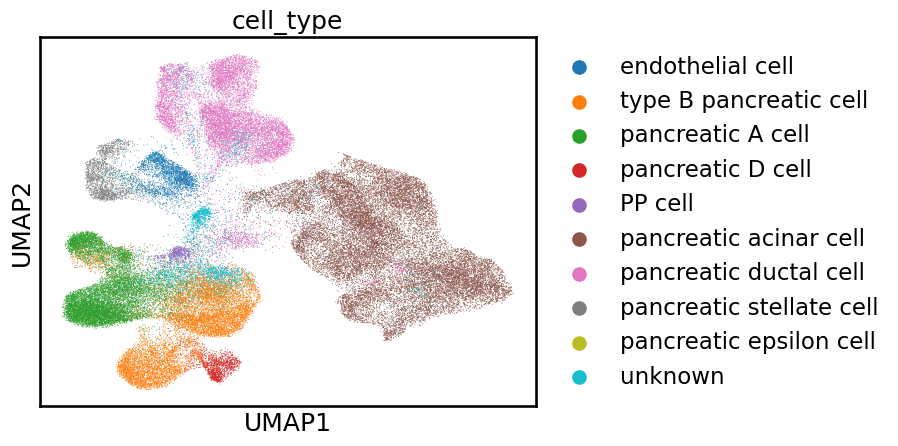

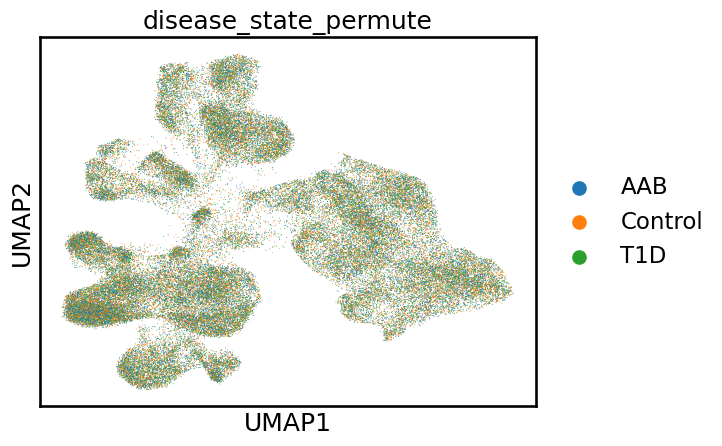

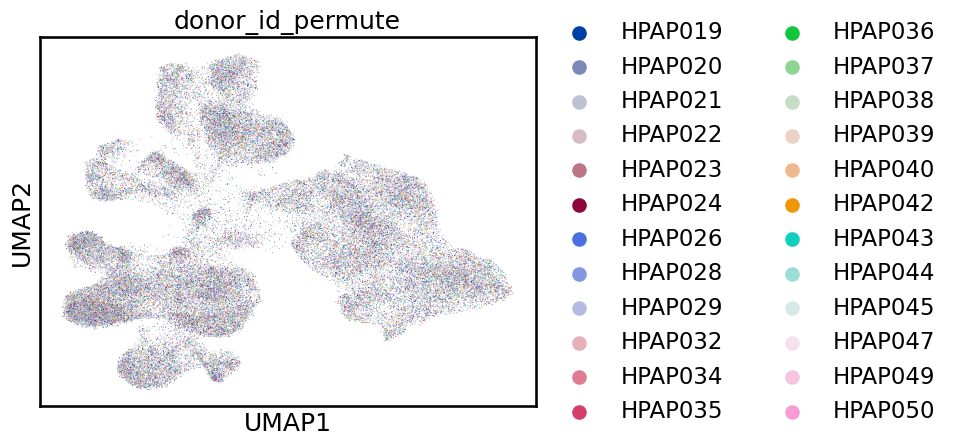

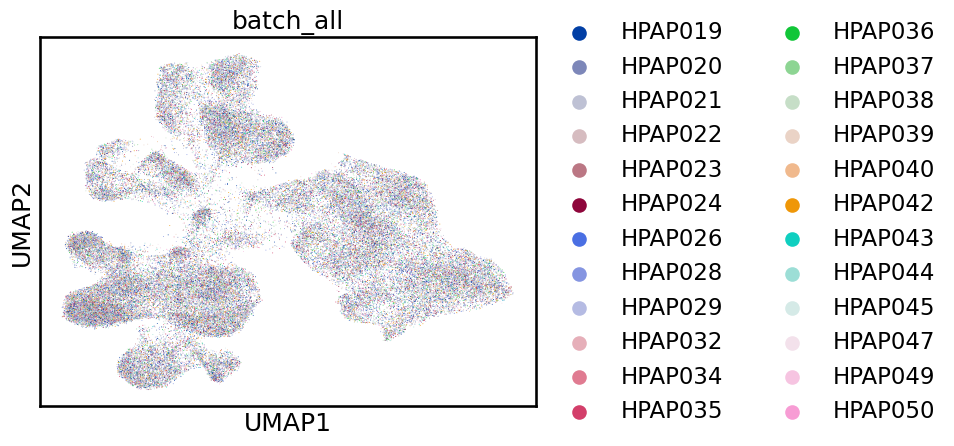

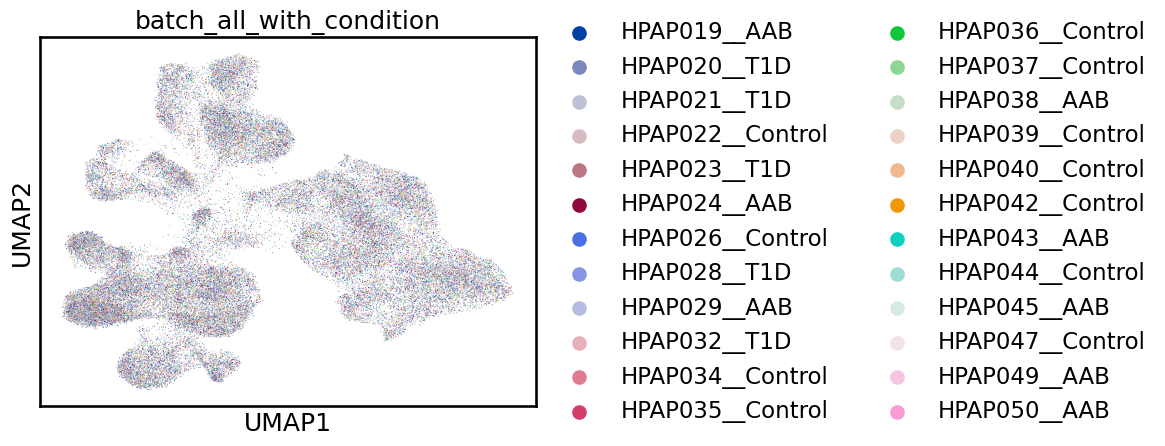

Plot of denoised expression


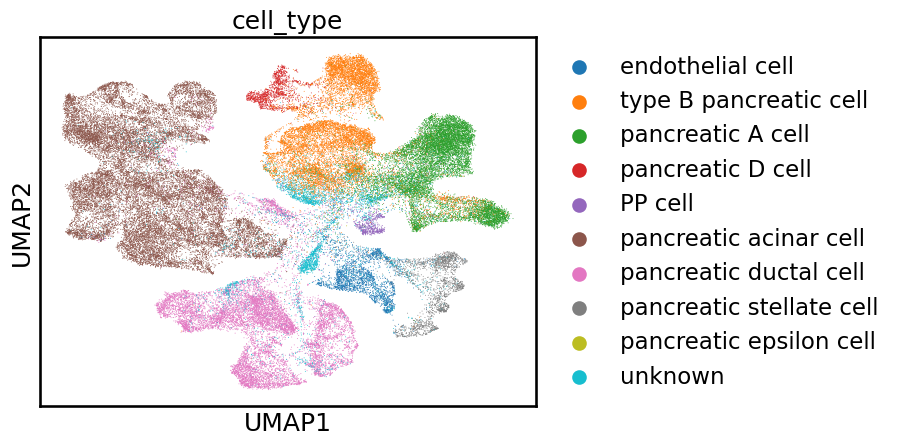

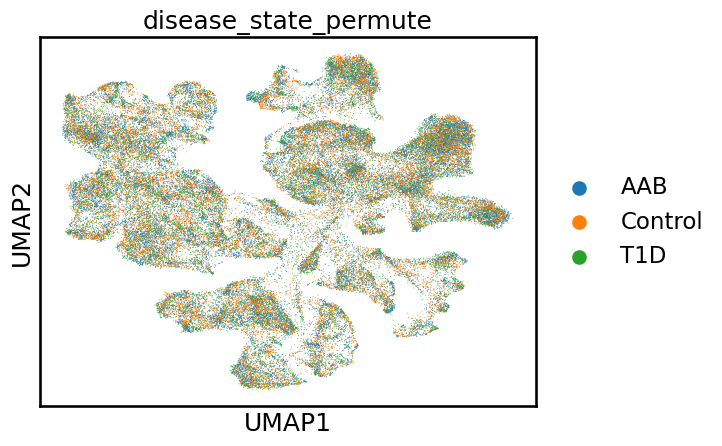

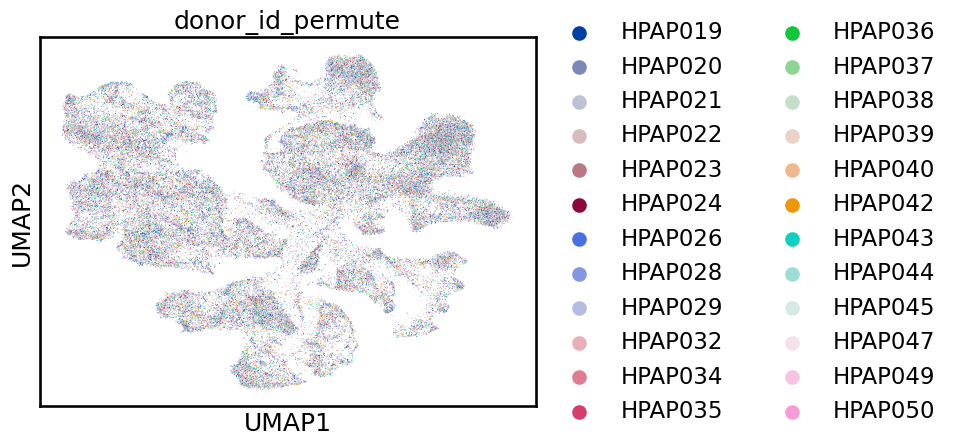

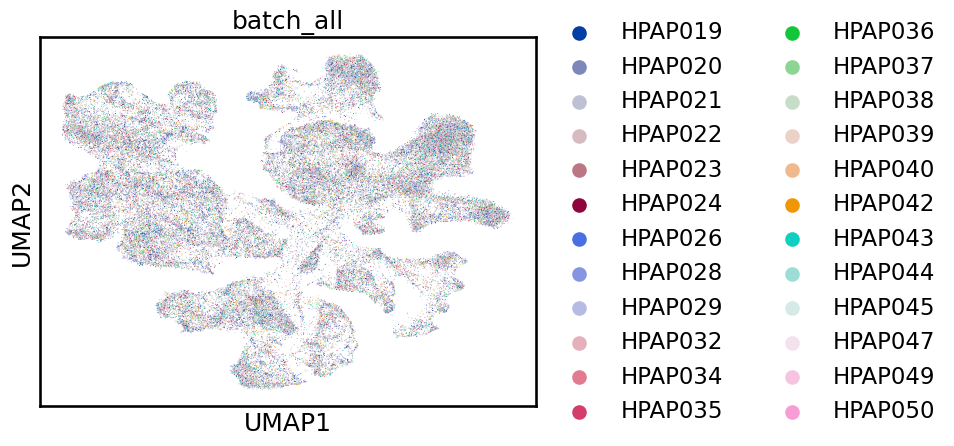

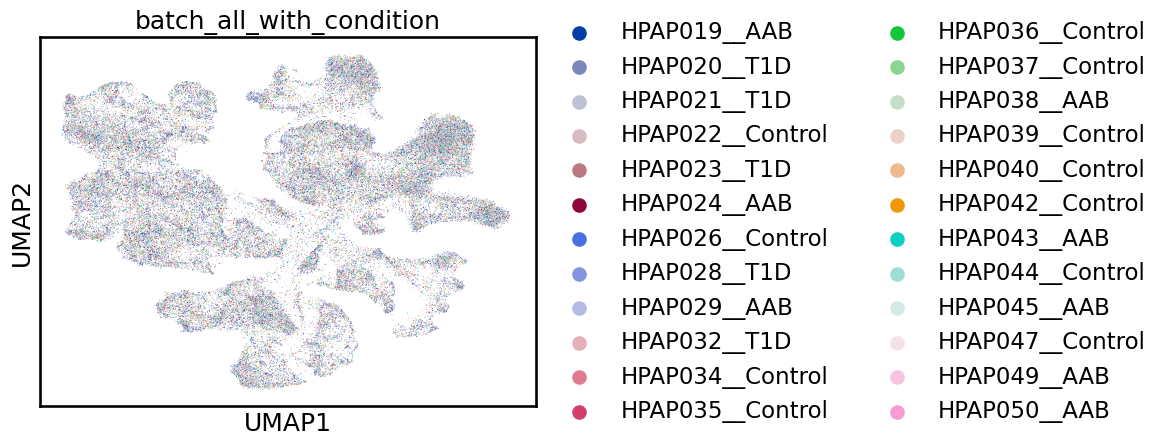

Finish adata preprocessing ====================
Batch effect:
condition-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9749939653624418 0.8085037818568518 0.8839779130780333


ASW---


asw_label 0.6055950447916985


asw_batch 0.9912515907658254


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


kbet_score 0.9181433282465116


graph_conn 0.8889366098210105


NMI, ARI ---
NMI 0.6719756120390054
ARI 0.6023989355273438
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.605595  0.602399  0.671976  0.974994  0.808504   0.991252   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.918143            0.888937        0.0  0.889698   

       true pos rate   F1 LISI  
X_pca        0.88404  0.883978  
batch-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9749939653624418 0.3149266576163754 0.4760782721632201


ASW---


asw_label 0.6055950447916985


asw_batch 0.9278786974806982


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


kbet_score 0.9422224308215121
graph_conn 0.8889366098210105


NMI, ARI ---
NMI 0.6719756120390054
ARI 0.6023989355273438
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.605595  0.602399  0.671976  0.974994  0.314927   0.927879   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.942222            0.888937        0.0  0.889698   

       true pos rate   F1 LISI  
X_pca       0.773738  0.476078  
batch-condition-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9749939653624418 0.3149266576163754 0.4760782721632201


ASW---


asw_label 0.6055950447916985


asw_batch 0.9278786974806982


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


kbet_score 0.9409348015804345


graph_conn 0.8889366098210105


NMI, ARI ---
NMI 0.6719756120390054
ARI 0.6023989355273438
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.605595  0.602399  0.671976  0.974994  0.314927   0.927879   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.940935            0.888937        0.0  0.889698   

       true pos rate   F1 LISI  
X_pca       0.773738  0.476078  
Within each unique condition, evaluate the batch effect of the denoised expression
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating AAB
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9764897944427555 0.6167999719997421 0.7560443687718403


ASW---


asw_label 0.6127529889345169


asw_batch 0.9403297246143447


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


Adding diffusion to step 7
Adding diffusion to step 8


kbet_score 0.8556520720850298
graph_conn 0.856364856493087


NMI, ARI ---
NMI 0.6292034730892079
ARI 0.42162191079033756
positive and true positive rate---


       ASW_label       ARI       NMI  1-cLISI   bLISI  ASW_batch  \
X_pca   0.612753  0.421622  0.629203  0.97649  0.6168    0.94033   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.855652            0.856365        0.0  0.897584   

       true pos rate   F1 LISI  
X_pca       0.883686  0.756044  


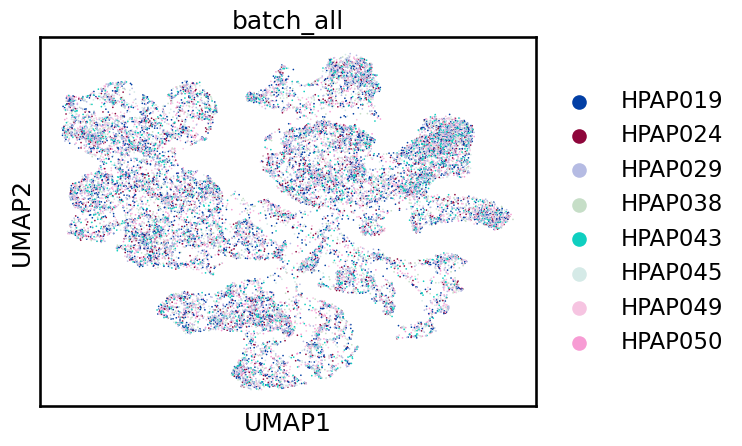

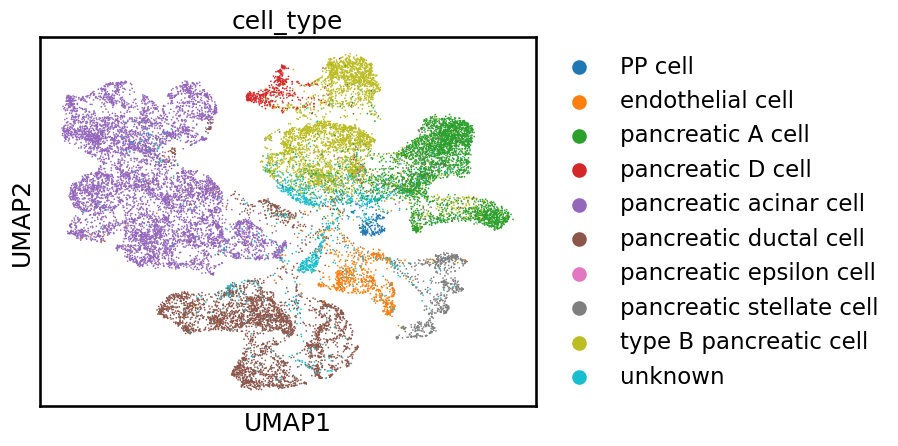

********************
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating Control
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9748802613942573 0.5014448307142765 0.6622507065071203


ASW---


asw_label 0.6162948161363602


asw_batch 0.9018489164676629


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 6
Adding diffusion to step 7


Adding diffusion to step 8


kbet_score 0.8283480370278281
graph_conn 0.8697434327894215


NMI, ARI ---
NMI 0.6791651144129897
ARI 0.6051698829443527
positive and true positive rate---


       ASW_label      ARI       NMI  1-cLISI     bLISI  ASW_batch  \
X_pca   0.616295  0.60517  0.679165  0.97488  0.501445   0.901849   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.828348            0.869743        0.0  0.894864   

       true pos rate   F1 LISI  
X_pca       0.861736  0.662251  


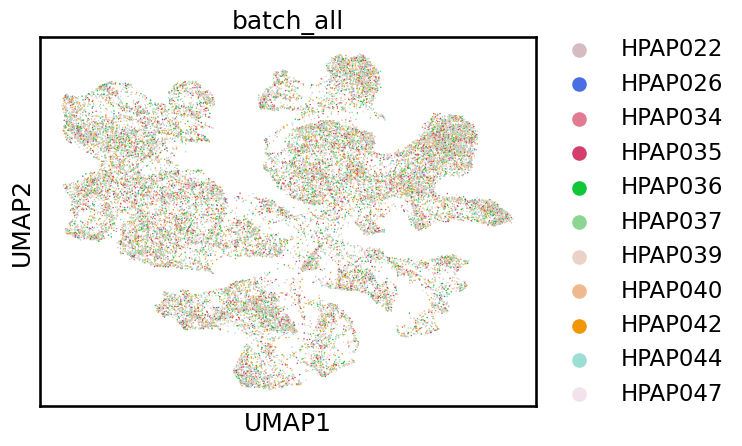

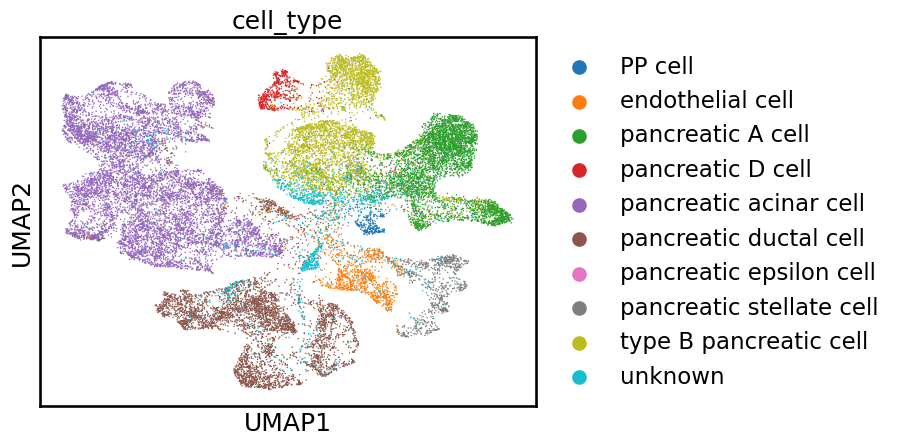

********************
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating T1D
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9771507394098158 0.5561507230080577 0.7088535471083006


ASW---


asw_label 0.6093735098838806


asw_batch 0.961446865852708


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 14


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


Adding diffusion to step 7
Adding diffusion to step 8


Adding diffusion to step 9


kbet_score 0.9418462759537203
graph_conn 0.8576524415128105


NMI, ARI ---
NMI 0.6279693533175535
ARI 0.5087198391625447
positive and true positive rate---


       ASW_label      ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.609374  0.50872  0.627969  0.977151  0.556151   0.961447   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.941846            0.857652        0.0  0.898214   

       true pos rate   F1 LISI  
X_pca       0.891384  0.708854  


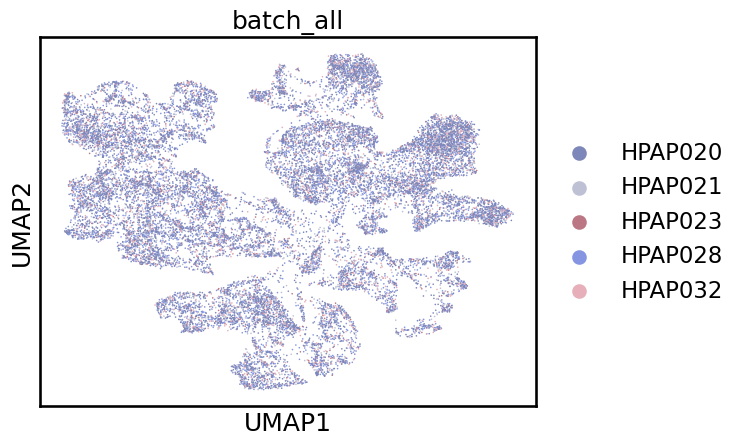

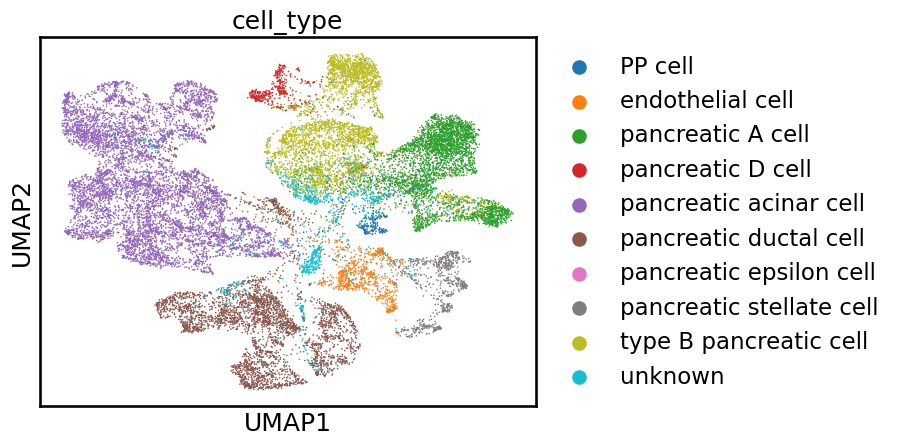

********************
Batch-related mixing performance evaluation for main effect:


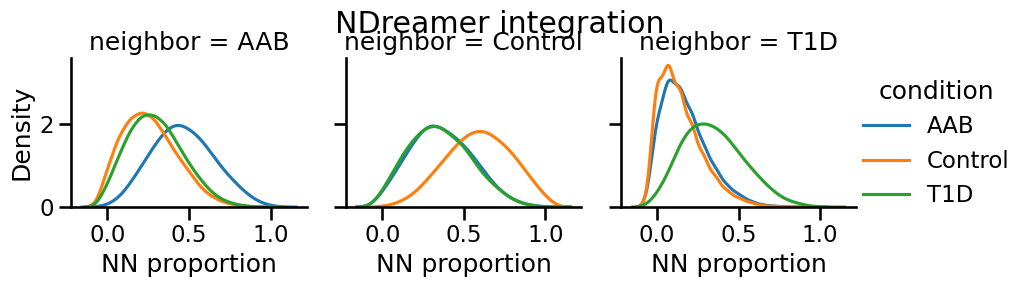

neighbor        AAB   Control       T1D
condition                              
AAB        0.463305  0.364725  0.171970
Control    0.262078  0.591344  0.146577
T1D        0.296342  0.355778  0.347879


In [9]:
i=1
evaluate_ndreamer_batch(dataset_name=dataset_names[i],cell_type_key=cell_type_keys[i],batch_key=batch_keys[i],condition_key=condition_keys[i])